###### Import Libraries

In [13]:
from sklearn.metrics import roc_auc_score,classification_report, accuracy_score, confusion_matrix, roc_curve
from matplotlib import pyplot as plt
import numpy as np
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Explainability
import lime
import lime.lime_tabular

In [14]:
df=pd.read_csv('../Data/Processed.csv')
df.head()

year  customer_id  phone_no  gender  age  no_of_days_subscribed  \
0  2015       100198  409-8743  Female   36                     62   
1  2015       100643  340-5930  Female   39                    149   
2  2015       100756  372-3750  Female   65                    126   
3  2015       101595  331-4902  Female   24                    131   
4  2015       101653  351-8398  Female   40                    191   

  multi_screen mail_subscribed  weekly_mins_watched  minimum_daily_mins  \
0           no              no               148.35                12.2   
1           no              no               294.45                 7.7   
2           no              no                87.30                11.9   
3           no             yes               321.30                 9.5   
4           no              no               243.00                10.9   

   maximum_daily_mins  weekly_max_night_mins  videos_watched  \
0               16.81                     82               1   
1               33.37                     87               3   
2                9.89                     91               1   
3               36.41                    102               4   
4               27.54                     83               7   

   maximum_days_inactive  customer_support_calls  churn  gender_code  \
0                    4.0                       1    0.0          0.0   
1                    3.0                       2    0.0          0.0   
2                    4.0                       5    1.0          0.0   
3                    3.0                       3    0.0          0.0   
4                    3.0                       1    0.0          0.0   

   multi_screen_code  mail_subscribed_code  
0                0.0                   0.0  
1                0.0                   0.0  
2                0.0                   0.0  
3                0.0                   1.0  
4                0.0                   0.0

In [15]:
df.shape

(1918, 19)

In [16]:
df.churn.value_counts()

0.0    1665
1.0     253
Name: churn, dtype: int64

##### Sampling the data

In [17]:
def prepare_model_smote(df,class_col,cols_to_exclude):
    cols=df.select_dtypes(include=np.number).columns.tolist() 
    X=df[cols]
    X = X[X.columns.difference([class_col])]
    X = X[X.columns.difference(cols_to_exclude)]
    y=df[class_col]
    global X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    tl = TomekLinks(sampling_strategy='majority')
    x_tl, y_tl = tl.fit_resample(X_train,y_train)

    sm = SMOTE()
    x_smote, y_smote = sm.fit_resample(x_tl, y_tl)
    
    return x_smote, y_smote, X_test, y_test

x_smote, y_smote, X_test, y_test = prepare_model_smote(df,class_col = 'churn',
                                                       cols_to_exclude=['customer_id','phone_no', 'year'])

In [54]:
x_smote.shape, X_test.shape, y_smote.shape, y_test.shape

((2168, 12), (576, 12), (2168,), (576,))

In [20]:
y_smote.value_counts()

0.0    1084
1.0    1084
Name: churn, dtype: int64

###### Baseline Model

In [21]:
# define the random forest model
def run_model(X_train,X_test,y_train,y_test):
    
    #Defines the logistic regression model as a global model that can be used outside of this function
    global logreg 
    
    ##Fitting the random forest
    logreg = LogisticRegression(random_state = 13)
    logreg.fit(X_train, y_train)
    
    ##Predicting y values
    global y_pred #Defines the Y_Pred as a global variable that can be used outside of this function
    y_pred = logreg.predict(X_test)
    
    ## Accuracy Reports
    randomforest_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
    print(classification_report(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))
    print("The area under the curve is: %0.2f"%randomforest_roc_auc)

In [22]:
# fit and run the logistic regression; evaluate the corresponding metrics 
run_model(x_smote,X_test,y_smote,y_test)

              precision    recall  f1-score   support

         0.0       0.96      0.76      0.85       513
         1.0       0.27      0.73      0.40        63

    accuracy                           0.76       576
   macro avg       0.62      0.75      0.62       576
weighted avg       0.88      0.76      0.80       576

0.7586805555555556
The area under the curve is: 0.75


In [23]:
# this results in probabilities for the target (0 and 1) 
logreg.predict_proba(X_test)

array([[0.45797406, 0.54202594],
       [0.91140451, 0.08859549],
       [0.43497862, 0.56502138],
       ...,
       [0.28657477, 0.71342523],
       [0.52015201, 0.47984799],
       [0.63127112, 0.36872888]])

#### RandomForest Model

In [61]:
# define the random forest model
def run_model(X_train,X_test,y_train,y_test):
    
    #Defines the random forest model as a global model that can be used outside of this function
    global randomforest 
    
    ##Fitting the random forest
    randomforest = RandomForestClassifier(max_depth=5)
    randomforest.fit(X_train, y_train)
    
    ##Predicting y values
    global y_pred #Defines the Y_Pred as a global variable that can be used outside of this function
    y_pred = randomforest.predict(X_test)
    
    ## Accuracy Reports
    randomforest_roc_auc = roc_auc_score(y_test, randomforest.predict(X_test))
    print(classification_report(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))
    print("The area under the curve is: %0.2f"%randomforest_roc_auc)
    
    logit_roc_auc = roc_auc_score(y_test, y_pred)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    #Setting the graph area
    plt.figure()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    #Plotting the worst line possiple
    plt.plot([0, 1], [0, 1],'b--')

    #Plotting the logistic regression we have built
    plt.plot(fpr, tpr, color='darkorange', label='Model (area = %0.2f)' % logit_roc_auc)

    #Adding labels and etc
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show();
    
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94       513
         1.0       0.51      0.83      0.63        63

    accuracy                           0.90       576
   macro avg       0.75      0.86      0.79       576
weighted avg       0.93      0.90      0.91       576

0.8958333333333334
The area under the curve is: 0.86


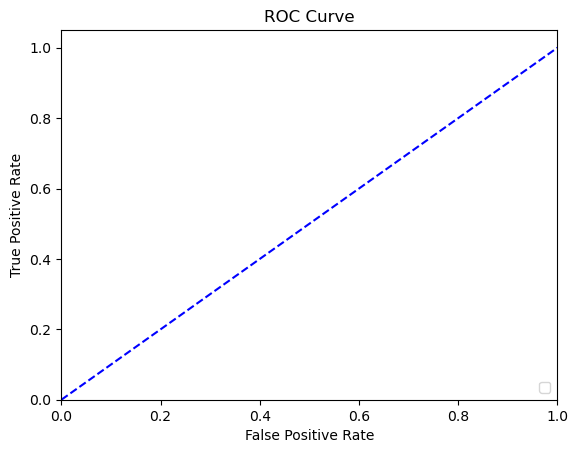

In [62]:
# fit and run the random forest model; evaluate the corresponding metrics 
run_model(x_smote,X_test,y_smote,y_test)

In [26]:
# this results in probabilities for the target (0 and 1) 
randomforest.predict_proba(X_test)

array([[0.36290015, 0.63709985],
       [0.81567894, 0.18432106],
       [0.36461414, 0.63538586],
       ...,
       [0.68328151, 0.31671849],
       [0.81241079, 0.18758921],
       [0.80123961, 0.19876039]])

#### AdaBoost

In [27]:
# define an adaboost model
def run_model(X_train,X_test,y_train,y_test):
    global adaboost #Defines the adaboost model as a global model that can be used outside of this function
    
    ##Fitting the random forest
    adaboost = AdaBoostClassifier(n_estimators = 100)
    adaboost.fit(X_train, y_train)
    
    ##Predicting y values
    global y_pred #Defines the Y_Pred as a global variable that can be used outside of this function
    y_pred = adaboost.predict(X_test)
    
    adaboost_roc_auc = roc_auc_score(y_test, adaboost.predict(X_test))
    print(classification_report(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))
    print("The area under the curve is: %0.2f"%adaboost_roc_auc)

In [28]:
# fit and run the adaboost model; evaluate the corresponding metrics 
run_model(x_smote,X_test,y_smote,y_test)

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       513
         1.0       0.49      0.57      0.53        63

    accuracy                           0.89       576
   macro avg       0.72      0.75      0.73       576
weighted avg       0.90      0.89      0.89       576

0.8888888888888888
The area under the curve is: 0.75


In [29]:
# this results in probabilities for the target (0 and 1) 
adaboost.predict_proba(X_test)

array([[0.50220785, 0.49779215],
       [0.50946664, 0.49053336],
       [0.50022124, 0.49977876],
       ...,
       [0.50015375, 0.49984625],
       [0.50594696, 0.49405304],
       [0.50708925, 0.49291075]])

# **Gradient Boost Model**

In [30]:
# define an adaboost model
def run_model(X_train,X_test,y_train,y_test):
    global gradientboost #Defines the gradientboostt model as a global model that can be used outside of this function
    
    ##Fitting the random forest
    gradientboost = GradientBoostingClassifier()
    gradientboost.fit(X_train, y_train)
    
    ##Predicting y values
    global y_pred #Defines the Y_Pred as a global variable that can be used outside of this function
    y_pred = gradientboost.predict(X_test)
    
    gradientboost_roc_auc = roc_auc_score(y_test, gradientboost.predict(X_test))
    print("The classification Report is: \n", classification_report(y_test, y_pred))
    print("The accuracy score is:", accuracy_score(y_test, y_pred))
    print("The area under the curve is: %0.2f"%gradientboost_roc_auc)

In [31]:
# fit and run the adaboost model; evaluate the corresponding metrics 
run_model(x_smote,X_test,y_smote,y_test)

The classification Report is: 
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       513
         1.0       0.74      0.78      0.76        63

    accuracy                           0.95       576
   macro avg       0.86      0.87      0.86       576
weighted avg       0.95      0.95      0.95       576

The accuracy score is: 0.9461805555555556
The area under the curve is: 0.87


In [32]:
# this results in probabilities for the target (0 and 1) 
gradientboost.predict_proba(X_test)

array([[0.33122382, 0.66877618],
       [0.95457868, 0.04542132],
       [0.18505316, 0.81494684],
       ...,
       [0.85841243, 0.14158757],
       [0.88605676, 0.11394324],
       [0.94876129, 0.05123871]])

## **Evaluating the Models**

In [52]:
# define a fucntion for plotting the ROC curves
def roc_curve(model,X_test,y_test):
    logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    
    global y_pred #Defines the Y_Pred as a global variable that can be used outside of this function
    y_pred = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    #Setting the graph area
    plt.figure()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    #Plotting the worst line possiple
    plt.plot([0, 1], [0, 1],'b--')

    #Plotting the logistic regression we have built
    plt.plot(fpr, tpr, color='darkorange', label='Model (area = %0.2f)' % logit_roc_auc)

    #Adding labels and etc
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show();

In [53]:
# ROC curve for random forest model
roc_curve(randomforest,X_test,y_test)

TypeError: roc_curve() missing 1 required positional argument: 'y_test'

In [149]:
# ROC curve for adaboost model
roc_curve (adaboost,X_test,y_test)

TypeError: roc_curve() missing 1 required positional argument: 'y_test'

## Feature Importance

In [42]:
# define a function for plotting the feature importances
def plot_feature_importances(model):
    feature_importances = pd.Series(model.feature_importances_, index=model.feature_names_in_)
    feature_importances = feature_importances.sort_values(axis=0, ascending=False)
    fig, ax = plt.subplots()
    feature_importances.plot.bar()
    ax.set_title("Feature importances")
    fig.tight_layout()

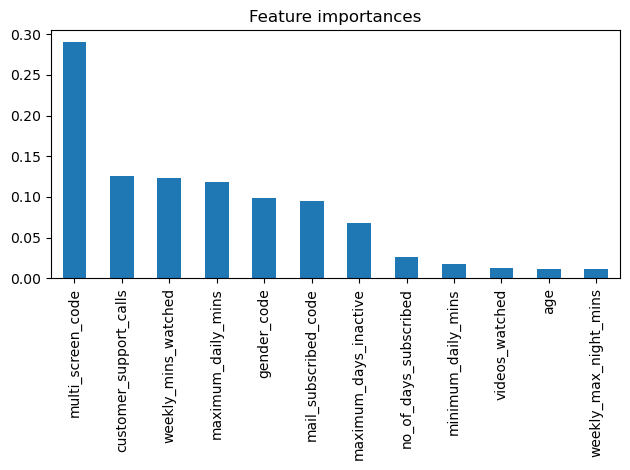

In [43]:
# feature importances for random forest model
plot_feature_importances(randomforest)

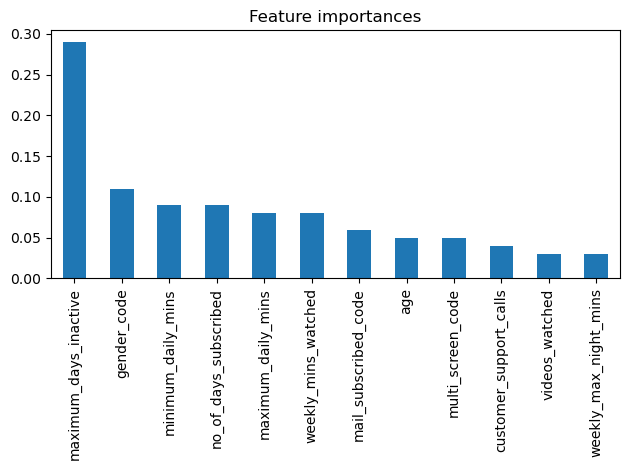

In [44]:
# feature importances for adaboost model
plot_feature_importances(adaboost)

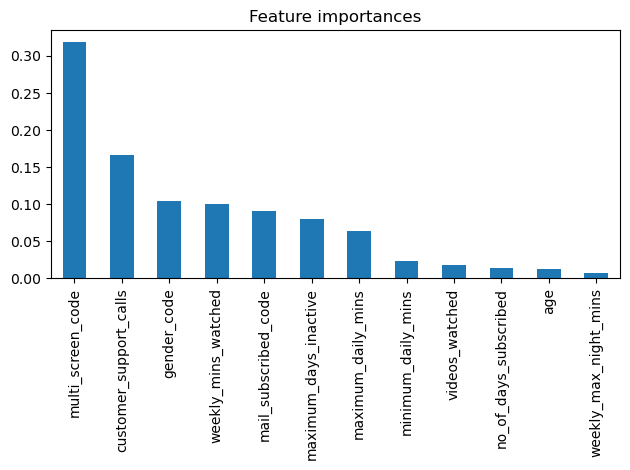

In [45]:
# feature importances for gradient boost model
plot_feature_importances(gradientboost)

###### Lime Explainability

In [46]:
# define a function for lime - local interpretable model-agnostic explanations
def lime_explanation(model,X_train,X_test,class_names,chosen_index):
  import lime
  import lime.lime_tabular
  explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,feature_names = X_train.columns,class_names=class_names,kernel_width=5)
  choosen_instance = X_test.loc[[chosen_index]].values[0]
  exp = explainer.explain_instance(choosen_instance, lambda x: model.predict_proba(x).astype(float),num_features=10)
  exp.show_in_notebook(show_all=False)

In [47]:
# implement the lime function
lime_explanation(gradientboost,X_train,X_test,['Not Churn','Churn'],1)

In [48]:
# define a function for creating lime list
def lime_explanation_list(model,X_train,X_test,class_names,chosen_index):
  import lime
  import lime.lime_tabular
  explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,feature_names = X_train.columns,class_names=class_names,kernel_width=5)
  choosen_instance = X_test.loc[[chosen_index]].values[0]
  exp = explainer.explain_instance(choosen_instance, lambda x: model.predict_proba(x).astype(float),num_features=10)
  return exp.as_list()

In [49]:
# lime implementation results in form of a list
lime_explanation_list(gradientboost,X_train,X_test,['Not Churn','Churn'],1)

[('multi_screen_code <= 0.00', -0.335227385350504),
 ('maximum_days_inactive <= 3.00', 0.23537303905276769),
 ('mail_subscribed_code <= 0.00', 0.12408029318215023),
 ('1.00 < customer_support_calls <= 2.00', -0.04408315492281071),
 ('269.02 < weekly_mins_watched <= 325.80', -0.039366479767015766),
 ('gender_code <= 0.00', -0.03407029215949005),
 ('30.49 < maximum_daily_mins <= 36.92', -0.02686549641675062),
 ('37.00 < age <= 43.00', -0.02393749564014051),
 ('videos_watched <= 3.00', 0.022861688108247694),
 ('weekly_max_night_mins <= 87.00', -0.019381299919289326)]